# Text Exploration

## Imports

In [1]:
## Basic Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

In [2]:
# NLP processing 
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
# wordcloud
from wordcloud import WordCloud, STOPWORDS

In [4]:
# sklearn models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split

## Constants

In [5]:
# path to csv file with data
PATH = '..\data\clean\electronics_small.csv'
SAMPLE_PATH = '..\data\clean\electronics_sample.csv'

In [6]:
# Dtypes and data column
DTYPES = {
    'overall':np.int16,
    'vote':np.int64,
    'verified':bool,
    'reviewText':object,
    'summary':object
}

PARSE_DATES = [3]

In [7]:
# number of rows to load
# for efficiency text exploration would be only for 10_000 rows
NROWS = 20_000

## Functions

In [8]:
# preprocessing text
def lemma(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.is_alpha and token.lemma_ != '-PRON-'])

## Loading Data

In [9]:
## Loading Data
df = pd.read_csv(PATH, dtype=DTYPES, parse_dates=PARSE_DATES, low_memory=True)

In [10]:
# calculating rating counts (1 to 5 stars)
rating_cnt = df.overall.value_counts()
rating_cnt

5    1909431
4     520339
3     228272
1     205790
2     136168
Name: overall, dtype: int64

In [11]:
# calculating weights for stratified sampling
rating_weights = rating_cnt.sum()/rating_cnt
rating_weights

5     1.571149
4     5.765472
3    13.142216
1    14.577968
2    22.031608
Name: overall, dtype: float64

In [12]:
# adding column with weights
df['weights']=df.overall.map(rating_weights)

In [13]:
# collecting stratified sample from dataframe
df_sample = df.sample(NROWS, replace=False,
                      weights='weights',
                      random_state=42 ).copy().drop(labels=['verified','weights'], axis=1).drop_duplicates()
df = None

In [14]:
# saving stratified data to csv
df_sample.to_csv(SAMPLE_PATH,index=False)

In [15]:
df_new = pd.read_csv(SAMPLE_PATH, dtype=DTYPES, parse_dates=[2]).dropna()

In [16]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19808 entries, 0 to 19808
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   overall     19808 non-null  int16         
 1   vote        19808 non-null  int64         
 2   reviewTime  19808 non-null  datetime64[ns]
 3   reviewText  19808 non-null  object        
 4   summary     19808 non-null  object        
dtypes: datetime64[ns](1), int16(1), int64(1), object(2)
memory usage: 812.4+ KB


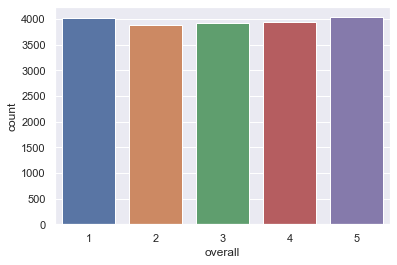

In [17]:
sns.countplot(x='overall', data=df_new)
plt.show()

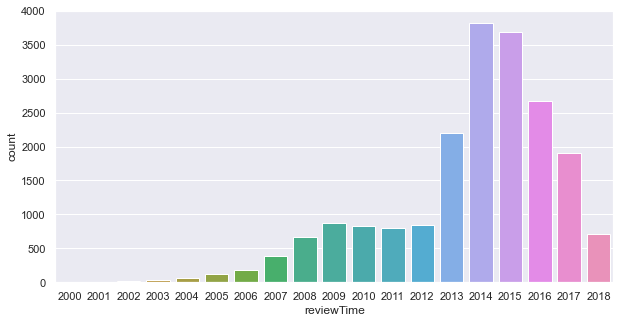

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=df_new.reviewTime.dt.year, ax=ax)
plt.show()

In [19]:
df_new.vote.value_counts()[:10]

0     15869
2      1119
3       682
4       386
5       321
6       222
7       157
8       121
10      100
9        90
Name: vote, dtype: int64

In [20]:
df_new['cleanReview'] = df_new.reviewText.apply(lemma)

In [21]:
# Getting read of reviews that include only information about the number of stars
war_1 = df_new.cleanReview.str.contains('one star')
war_2 = df_new.cleanReview.str.contains('two star')
war_3 = df_new.cleanReview.str.contains('three star')
war_4 = df_new.cleanReview.str.contains('four star')
war_5 = df_new.cleanReview.str.contains('five star')

mask = (~war_1 & ~war_2 & ~war_3 & ~war_4 & ~war_5)
df_new = df_new[mask]

In [22]:
df_new.loc[:,'word_cnt'] = df_new['cleanReview'].str.split().str.len()

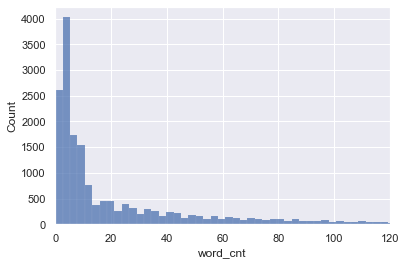

In [23]:
sns.histplot(x='word_cnt', data=df_new)
plt.xlim([0,120])
plt.show()

In [24]:
word_mean = df_new.word_cnt.mean().round(2)
word_std = df_new.word_cnt.std().round(2)
upper, lower = word_mean + word_std, word_mean - word_std
print(upper, '-', lower)

120.42000000000002 - -42.440000000000005


In [25]:
df_new = df_new[(df_new.word_cnt < upper) & (df_new.word_cnt > 5)]
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10222 entries, 1 to 19807
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   overall      10222 non-null  int16         
 1   vote         10222 non-null  int64         
 2   reviewTime   10222 non-null  datetime64[ns]
 3   reviewText   10222 non-null  object        
 4   summary      10222 non-null  object        
 5   cleanReview  10222 non-null  object        
 6   word_cnt     10222 non-null  int64         
dtypes: datetime64[ns](1), int16(1), int64(2), object(3)
memory usage: 579.0+ KB


In [26]:
df_new.word_cnt.describe()

count    10222.000000
mean        31.713363
std         28.882754
min          6.000000
25%          9.000000
50%         20.000000
75%         46.000000
max        120.000000
Name: word_cnt, dtype: float64

## Word Clouds

In [27]:
wc_text = {}
for i in range(1,6):
    wc_text[i] = ' '.join(df_new[df_new.overall==i].cleanReview.to_list())

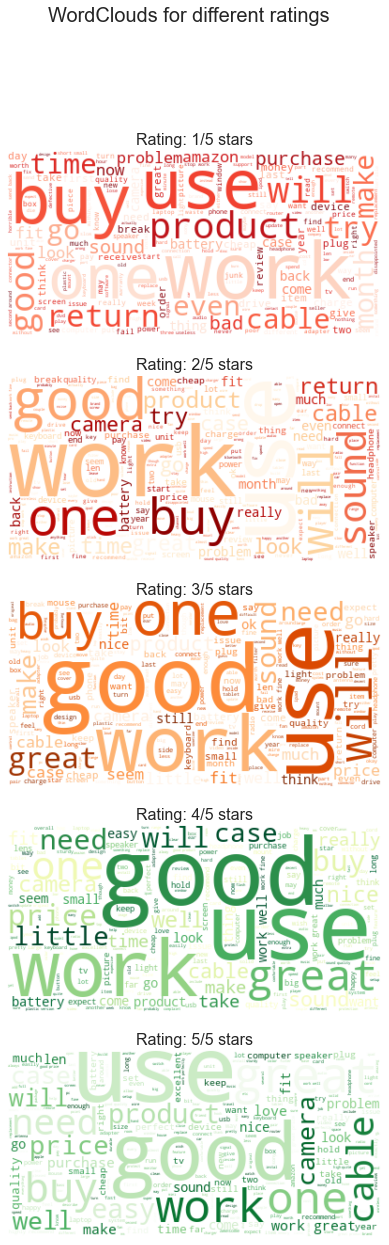

In [28]:
# Create stopword list:
stopwords = set(STOPWORDS)
cmaps = ['Reds','OrRd','Oranges','YlGn','Greens']

# Generate a word cloud image
wordclouds = {}
for i in range(1,6):
    wordclouds[i] = WordCloud(stopwords=stopwords,
                              max_words=1_000,
                              colormap=cmaps[i-1],
                              background_color="white").generate(wc_text[i])

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(5, figsize=(7,20))
fig.suptitle('WordClouds for different ratings', fontsize=20)
for i in range(1,6):
    ax[i-1].set_title(f'Rating: {i}/5 stars', fontsize=16)
    ax[i-1].imshow(wordclouds[i], interpolation='bilinear')
    ax[i-1].axis("off")
plt.show()

## Baseline Model

In [29]:
X = df_new['cleanReview']
y = df_new['overall']-1

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [31]:
# updating stopwords
stopwords = set(STOPWORDS)
stopwords.update(['product','buy', 'purchase'])
stopwords = list(stopwords)

In [32]:

# creating tfidf model
tfidf = TfidfVectorizer( max_df=0.9999,ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [33]:
print('Vocabulary Size: ', len(tfidf.get_feature_names()))

Vocabulary Size:  92786


In [34]:
rf = RandomForestClassifier(n_estimators=200, max_depth=20)
rf.fit(X_train_tfidf, y_train)
rf.score(X_test_tfidf, y_test)

0.37750611246943766

In [35]:
y_test_pred = rf.predict(X_test_tfidf)

In [36]:
cl_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).T
display(cl_report)

,precision,recall,f1-score,support
0,0.380734,0.752834,0.505712,441.000000
1,0.313043,0.086331,0.135338,417.000000
2,0.319544,0.529551,0.398577,423.000000
3,0.491071,0.141026,0.219124,390.000000
4,0.510204,0.334225,0.403877,374.000000
accuracy,0.377506,0.377506,0.377506,0.377506
macro avg,0.402919,0.368793,0.332526,2045.000000
weighted avg,0.398995,0.377506,0.334749,2045.000000


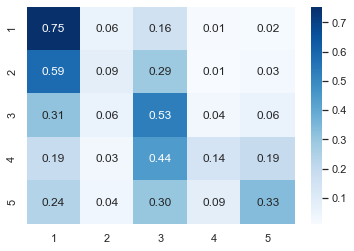

In [37]:
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm, cmap='Blues',
                yticklabels=range(1,6),
                xticklabels=range(1,6),
                annot=True, 
                fmt='.2f'
                )
plt.show()

In [38]:
gb = GradientBoostingClassifier(n_estimators=200, max_depth=20)
gb.fit(X_train_tfidf, y_train)
gb.score(X_test_tfidf, y_test)

0.34963325183374083

In [39]:
y_test_pred_gb = gb.predict(X_test_tfidf)

In [40]:
cl_report_gb = pd.DataFrame(classification_report(y_test, y_test_pred_gb, output_dict=True)).T
display(cl_report_gb)

,precision,recall,f1-score,support
0,0.430155,0.439909,0.434978,441.000000
1,0.318627,0.311751,0.315152,417.000000
2,0.292735,0.323877,0.307520,423.000000
3,0.311615,0.282051,0.296097,390.000000
4,0.394521,0.385027,0.389716,374.000000
accuracy,0.349633,0.349633,0.349633,0.349633
macro avg,0.349531,0.348523,0.348692,2045.000000
weighted avg,0.349865,0.349633,0.349416,2045.000000


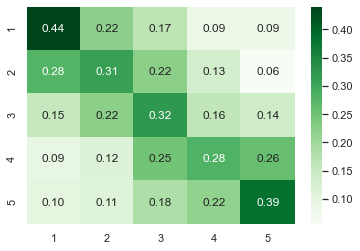

In [41]:
cm_gb = confusion_matrix(y_test, y_test_pred_gb, normalize='true')
sns.heatmap(cm_gb, cmap='Greens',
                yticklabels=range(1,6),
                xticklabels=range(1,6),
                annot=True, 
                fmt='.2f'
                )
plt.show()

In [42]:
feat_imp = pd.DataFrame({'feature':tfidf.get_feature_names(),'value':rf.feature_importances_})

In [43]:
feat_imp_most = feat_imp.sort_values(by='value', ascending=False)[:25]

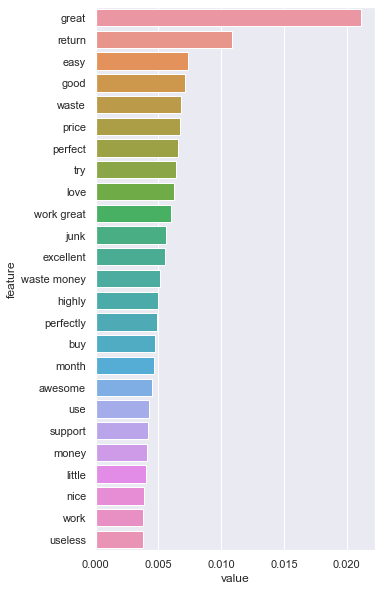

In [44]:
fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(y='feature', x='value', data=feat_imp_most, ax =ax)
plt.show()